# 教程

(320, 520, 3)
(285, 293, 13, 27)
(306, 255, 41, 50)
(210, 250, 25, 15)
(236, 236, 25, 15)
(251, 240, 3, 3)
(316, 202, 8, 6)
(325, 194, 57, 51)
(163, 53, 84, 94)
(163, 53, 84, 94)
(11, 53, 84, 95)
(11, 53, 84, 95)


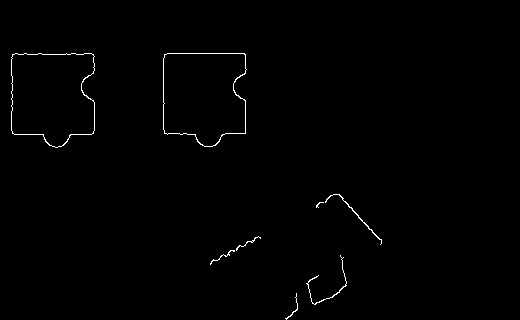

In [ ]:
import cv2
GAUSSIAN_BLUR_KERNEL_SIZE = (5, 5)
GAUSSIAN_BLUR_SIGMA_X = 0
CANNY_THRESHOLD1 = 200
CANNY_THRESHOLD2 = 450

image_raw = cv2.imread('captcha.png')  # OpenCV 读取图片

# 高斯滤波——对验证码图片进行高斯模糊滤波处理，消除部分噪声干扰
image = cv2.GaussianBlur(image_raw, GAUSSIAN_BLUR_KERNEL_SIZE, GAUSSIAN_BLUR_SIGMA_X)
print(image.shape)
# 边缘检测——对验证码图片应用边缘检测算法，通过调整相应阈值识别出滑块边缘
image = cv2.Canny(image, CANNY_THRESHOLD1, CANNY_THRESHOLD2)

# 轮廓提取——对上一步得到的各个边缘轮廓信息，通过对比面积、位置、周长等特征筛选出最可能的轮廓位置，得到缺口位置。
contours, _ = cv2.findContours(image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
for i in contours:
    print(cv2.boundingRect(i))  # 各个轮廓外界矩形的信息？
    # pass
# x, y, w, h

array = np.array(image)
show = Image.fromarray(array.astype('uint8'))
show

所以，我们需要先确定怎么来筛选，比如面积我们可以设定一个范围，周长设定一个范围，缺口位置设定一个范围，通过实际测量，我们可以得出:

目标缺口的

外接矩形的高度大约是验证码高度的 0.25 倍
宽度大约是验证码宽度的 0.15 倍。在允许误差 20% 的情况下，根据验证码的宽高信息我们大约可以计算出面积、周长的范围，同时缺口位置（缺口左侧）也有一个最小偏移值，比如最小偏移是验证码宽度的 0.2 倍，最大偏移是验证码宽度的 0.85 倍。综合这些内容，我们可以定义三个阈值方法：

In [ ]:
import cv2

GAUSSIAN_BLUR_KERNEL_SIZE = (5, 5)
GAUSSIAN_BLUR_SIGMA_X = 0
CANNY_THRESHOLD1 = 200
CANNY_THRESHOLD2 = 450

# 高斯滤波
def get_gaussian_blur_image(image):
    return cv2.GaussianBlur(image, GAUSSIAN_BLUR_KERNEL_SIZE, GAUSSIAN_BLUR_SIGMA_X)

# 边缘检测
def get_canny_image(image):
    return cv2.Canny(image, CANNY_THRESHOLD1, CANNY_THRESHOLD2)

# 轮廓提取
def get_contours(image):
    contours, _ = cv2.findContours(image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    return contours


# 缺口面积范围（20%误差）
def get_contour_area_threshold(image_width, image_height):
    contour_area_min = (image_width * 0.15) * (image_height * 0.25) * 0.8
    contour_area_max = (image_width * 0.15) * (image_height * 0.25) * 1.2
    return contour_area_min, contour_area_max

# 缺口周长范围（20%误差）
def get_arc_length_threshold(image_width, image_height):
    arc_length_min = ((image_width * 0.15) + (image_height * 0.25)) * 2 * 0.8
    arc_length_max = ((image_width * 0.15) + (image_height * 0.25)) * 2 * 1.2
    return arc_length_min, arc_length_max

# 最小偏移与最大偏移？？？
def get_offset_threshold(image_width):
    offset_min = 0.2  * image_width     # 缺口位置 最小偏移是验证码宽度的 0.2 倍
    offset_max = 0.85 * image_width     # 缺口位置 最大偏移是验证码宽度的 0.85 倍
    return offset_min, offset_max


def main():
    image_raw = cv2.imread('captcha.png')                      # 读取验证码图片文件
    image_height, image_width, _ = image_raw.shape              # 验证码图片的尺寸（高度、宽度）

    image_gaussian_blur = get_gaussian_blur_image(image_raw)    # 高斯滤波
    image_canny         = get_canny_image(image_gaussian_blur)  # 边缘检测
    contours            = get_contours(image_canny)             # 轮廓提取

    ### 图片存储
    cv2.imwrite('image_gaussian_blur.png', image_gaussian_blur) # 高斯滤波（模糊）
    cv2.imwrite('image_canny.png', image_canny)                 # 边缘检测

    ### 目标轮廓的面积、周长、偏移
    contour_area_min, contour_area_max = get_contour_area_threshold(image_width, image_height)
    arc_length_min,   arc_length_max   = get_arc_length_threshold(image_width, image_height)
    offset_min,       offset_max       = get_offset_threshold(image_width)
    offset = None

    ### 筛选出符合条件的轮廓 即为 验证码缺口轮廓
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)      # 轮廓的外界矩形
        '''
            cv2.contourArea(contour)    # 轮廓的面积
            cv2.arcLength(contour)      # 轮廓的周长
            x                           # 轮廓左上角位置
        '''
        if contour_area_min < cv2.contourArea(contour)     < contour_area_max and \
            arc_length_min  < cv2.arcLength(contour, True) < arc_length_max and \
            offset_min      < x                            < offset_max:
            
            cv2.rectangle(image_raw, (x, y), (x + w, y + h), (0, 0, 255), 2)    # 缺口标注
            offset = x                                                          # 缺口偏移
            cv2.imwrite('image_label.png', image_raw)                           # 标注后的图片存储
    print('offset', offset)                                                   # 输出缺口偏移



if __name__ == '__main__':
    main()

offset 163


# 果核剥壳



## 1.获取图片

- 初始通过 **`selenium`** 的 **`screenshot_as_png`** 方法获取验证码整体（包括**缺口**和**滑块**）

  目的是获取验证码滑块的初始偏移（**`offset`**）
    
- 后续通过 **网页源代码** 获取 src 链接进而获取验证码（仅包括 **缺口**）

### （1）通过 获取网页源代码中验证码图片的 `src` 链接获取图片

https://t.captcha.qq.com/hycdn?index=1&image=937518361926182912?aid=2058282041&sess=s0-I5uCbB2VwBsxgHzZOi-6_iUnOV-XmFbNwKxloyMgb5CrNHNczCQTEXGqeXMIk0roBuwfzark4pAVumfw13PxwFeDN3_3lYhY4z1toNU-2XcP5zxbb6lnjPAlK3Y2IwA1iFndcUOWWaOFglcePqriJk0jz1NA_3p08U1_gA4nYXCCkrLeYHe2XLMjsRPbqCmvCkKkmUNTwJEz7BO1-XTnnbsHlE0F6_VEr0QuFTEWdKwAJ29xnxr2x8sa9FAueE82H57bWI-UNJ2SY5pfd-Ip3Ag-Nk1nioccJ_a3zn-I7c*&sid=6958325838410846208&img_index=1&subsid=3
<class 'bytes'>
(680, 390)


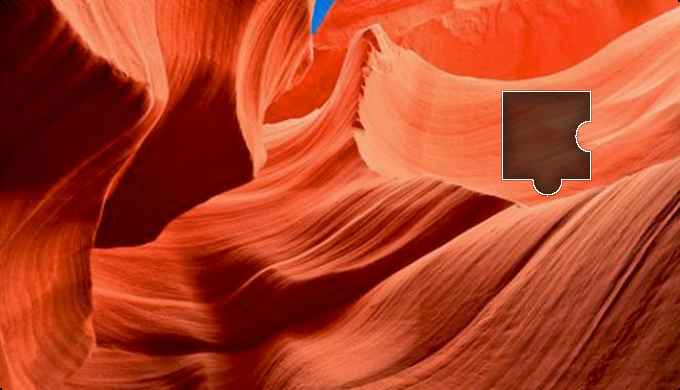

In [345]:
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import time
from selenium import webdriver
from selenium.webdriver.common.by import By

browser = webdriver.Chrome()

browser.get('https://www.ghxi.com/login')

browser.find_element(By.CSS_SELECTOR, '.captcha-button').click()
time.sleep(2)           # 待改进
browser.switch_to.frame('tcaptcha_iframe')
image_src = browser.find_element(By.CSS_SELECTOR, '#slideBg').get_attribute('src')
print(image_src)

# 根据验证码图片链接获取图片
image_by_src = requests.get(image_src).content
print(type(image_by_src))
image_by_src = Image.open(BytesIO(image_by_src))
print(np.size(image_by_src))
image_by_src

### （2）通过 **`selenium`** 的截图功能获取图片

In [458]:
import numpy as np
import requests
from PIL import Image
import time
from selenium import webdriver
from selenium.webdriver.common.by import By

browser = webdriver.Chrome()

browser.get('https://www.ghxi.com/login')

browser.find_element(By.CSS_SELECTOR, '.captcha-button').click()
time.sleep(2)
browser.switch_to.frame('tcaptcha_iframe')

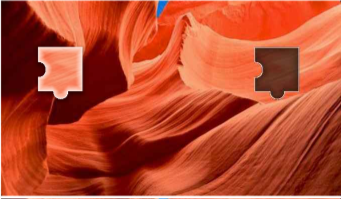

In [486]:
slideBgWrap = browser.find_element(By.CSS_SELECTOR, '#slideBgWrap')
image_by_screenshot = Image.open(BytesIO(slideBgWrap.screenshot_as_png))
image_by_screenshot

### 两种方法获得的图片测试

<class 'PIL.JpegImagePlugin.JpegImageFile'>
(390, 680, 3)


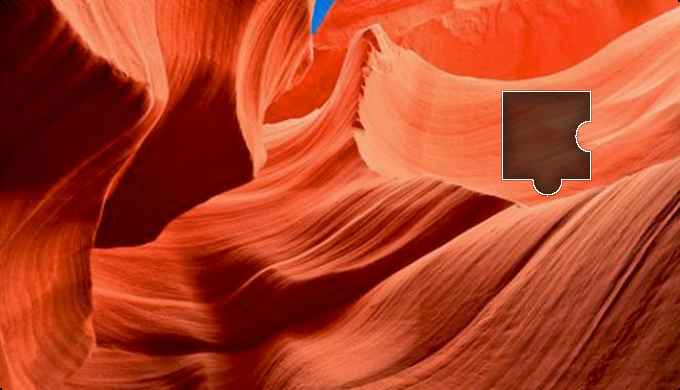

In [354]:
print(type(image_by_src))
print(np.array(image_by_src).shape)
image_by_src

<class 'PIL.PngImagePlugin.PngImageFile'>
(199, 341, 4)


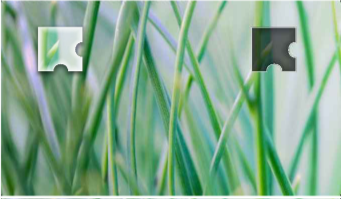

In [452]:
print(type(image_by_screenshot))
print(np.array(image_by_screenshot).shape)
image_by_screenshot

## 2.缺口识别测试

15


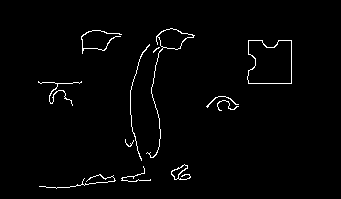

In [480]:
def image_test(img):
    image_raw = np.array(img)
    image = cv2.GaussianBlur(image_raw, GAUSSIAN_BLUR_KERNEL_SIZE, GAUSSIAN_BLUR_SIGMA_X)
    image = cv2.Canny(image, CANNY_THRESHOLD1, CANNY_THRESHOLD2)
    contours, _ = cv2.findContours(image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    print(len(contours))
    for contour in contours:
        # print(cv2.boundingRect(contour))  # 各个轮廓外界矩形的信息？  # x, y, w, h
        pass
    array = np.array(image)
    show = Image.fromarray(array.astype('uint8'))
    return show

import cv2
GAUSSIAN_BLUR_KERNEL_SIZE = (5, 5)
GAUSSIAN_BLUR_SIGMA_X = 0
CANNY_THRESHOLD1 = 200
CANNY_THRESHOLD2 = 450
image_test(image_by_screenshot)

## 3.获取待偏移值

In [487]:
import cv2

GAUSSIAN_BLUR_KERNEL_SIZE = (5, 5)
GAUSSIAN_BLUR_SIGMA_X = 0
CANNY_THRESHOLD1 = 200
CANNY_THRESHOLD2 = 450

# 高斯滤波
def get_gaussian_blur_image(image):
    return cv2.GaussianBlur(image, GAUSSIAN_BLUR_KERNEL_SIZE, GAUSSIAN_BLUR_SIGMA_X)

# 边缘检测
def get_canny_image(image):
    return cv2.Canny(image, CANNY_THRESHOLD1, CANNY_THRESHOLD2)

# 轮廓提取
def get_contours(image):
    contours, _ = cv2.findContours(image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    return contours

# 缺口面积范围（20%误差）
def get_contour_area_threshold(image_width, image_height):
    contour_area_min = (image_width * 0.132) * (image_height * 0.274) * 0.8
    contour_area_max = (image_width * 0.132) * (image_height * 0.274) * 1.2
    print('【面积范围】', contour_area_min, '——', contour_area_max)
    return contour_area_min, contour_area_max

# 缺口周长范围（20%误差）
def get_arc_length_threshold(image_width, image_height):
    arc_length_min = ((image_width * 0.132) + (image_height * 0.274)) * 2 * 0.8
    arc_length_max = ((image_width * 0.132) + (image_height * 0.274)) * 2 * 1.2
    print('【周长范围】', arc_length_min, '——', arc_length_max)
    return arc_length_min, arc_length_max

# 最小偏移与最大偏移？？？
def get_offset_threshold(image_width):
    offset_min = 0.2  * image_width     # 缺口位置 最小偏移是验证码宽度的 0.2 倍
    offset_max = 0.868 * image_width     # 缺口位置 最大偏移是验证码宽度的 0.85 倍
    print('【偏移范围】', offset_min, '——', offset_max)
    return offset_min, offset_max

【图片】 (199, 341, 4)
【面积范围】 1963.4594496000002 —— 2945.1891744
【周长范围】 159.26080000000002 —— 238.89120000000003
【偏移范围】 68.2 —— 295.988
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'PIL.Image.Image'>
【识别成功】
【轮廓信息】 (254, 47, 45, 52) 【面积】 2340 【周长】 194
【当前偏移offset】 254
【偏移值】 217
【识别成功】
【轮廓信息】 (254, 47, 45, 52) 【面积】 2340 【周长】 194
【当前偏移offset】 254
【偏移值】 217
【识别成功】
【轮廓信息】 (37, 46, 47, 58) 【面积】 2726 【周长】 210
【当前偏移offset】 37
【偏移值】 0
【识别成功】
【轮廓信息】 (37, 46, 47, 54) 【面积】 2538 【周长】 202
【当前偏移offset】 37
【偏移值】 0


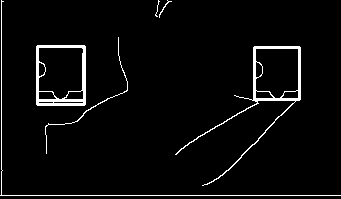

In [488]:
def test(img):
    image_raw = np.array(img)
    image_height, image_width, _ = image_raw.shape              # 验证码图片的尺寸（高度、宽度）
    print('【图片】', image_raw.shape)

    ### 目标轮廓的面积、周长、偏移
    contour_area_min, contour_area_max = get_contour_area_threshold(image_width, image_height)
    arc_length_min,   arc_length_max   = get_arc_length_threshold(image_width, image_height)
    offset_min,       offset_max       = get_offset_threshold(image_width)
    current_offset = None
    




    # 图片处理
    image_gaussian_blur = get_gaussian_blur_image(image_raw)    # 高斯滤波
    image_canny         = get_canny_image(image_gaussian_blur)  # 边缘检测
    contours            = get_contours(image_canny)             # 轮廓提取

    print(type(image_raw))
    print(type(image_canny))
    print(type(Image.fromarray(image_canny.astype('uint8'))))
    
    ### 筛选出符合条件的轮廓 即为 验证码缺口轮廓
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        # 绘制外框
        # rec_image = cv2.rectangle(image_canny, (x, y), (x + w, y + h), (255, 0, 0), 2)
        # rec_image = Image.fromarray(rec_image.astype('uint8'))

        # 面积周长计算
        # image_area = cv2.contourArea(contour)       # image_area = w * h
        # image_arc  = cv2.arcLength(contour, True)   # image_arc  = (w + h) * 2
        image_area = w * h
        image_arc  = (w + h) * 2
        
        # print('【轮廓信息】', (x, y, w, h), '【面积】', image_area, '【周长】', image_arc)
        
        # 条件判断
        if contour_area_min < image_area < contour_area_max and \
            arc_length_min  < image_arc  < arc_length_max and \
            0 < x < offset_max:
            # cv2.rectangle(image_raw, (x, y), (x + w, y + h), (255, 0, 0), 2)    # 缺口标注
            current_offset = x
            rec_image = cv2.rectangle(image_canny, (x, y), (x + w, y + h), (255, 0, 0), 2)
            rec_image = Image.fromarray(rec_image.astype('uint8'))
            offset = current_offset - 37
            print('【识别成功】')                                                          # 缺口偏移
            print('【轮廓信息】', (x, y, w, h), '【面积】', image_area, '【周长】', image_arc)
            print('【当前偏移offset】', current_offset)
            print('【偏移值】', current_offset - 37)
    return rec_image, offset
# if __name__ == '__main__':
test(image_by_screenshot)[0]

## 滑动操作

In [489]:
from selenium.webdriver import ActionChains
browser.switch_to.frame('tcaptcha_iframe')
ready = browser.find_element(By.CSS_SELECTOR, '#tcaptcha_drag_thumb')
actions = ActionChains(browser)
offset = test(image_by_screenshot)[1]
actions.drag_and_drop_by_offset(ready, offset-1, 0)
actions.drag_and_drop_by_offset(ready, 1, 0)
actions.perform()

# 崔庆才示例网站

In [301]:
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from io import BytesIO
import numpy as np

browser = webdriver.Chrome()
browser.get('https://captcha1.scrape.center/')
time.sleep(2)
browser.find_element(By.CSS_SELECTOR, 'input[type="text"]').send_keys('admin')
browser.find_element(By.CSS_SELECTOR, 'input[type="password"]').send_keys('admin')
time.sleep(2)
browser.find_element(By.CSS_SELECTOR, 'button').click()

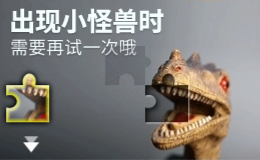

In [302]:
image = browser.find_element(By.CSS_SELECTOR, 'canvas.geetest_canvas_slice').screenshot_as_png
image = Image.open(BytesIO(image))
image

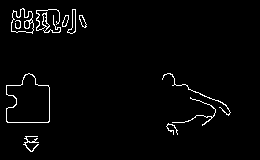

In [303]:
GAUSSIAN_BLUR_KERNEL_SIZE = (5, 5)
GAUSSIAN_BLUR_SIGMA_X = 0
CANNY_THRESHOLD1 = 200
CANNY_THRESHOLD2 = 450

image_raw = np.array(image)
image_test = cv2.GaussianBlur(image_raw, GAUSSIAN_BLUR_KERNEL_SIZE, GAUSSIAN_BLUR_SIGMA_X)
image_test = cv2.Canny(image_test, CANNY_THRESHOLD1, CANNY_THRESHOLD2)
contours, _ = cv2.findContours(image_test, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

array = np.array(image_test)
show = Image.fromarray(array.astype('uint8'))
show

In [ ]:
print(len(contours))
for i in contours:
    print(cv2.boundingRect(i))  # 各个轮廓外界矩形的信息？  # x, y, w, h
    # pass

In [294]:
import cv2

GAUSSIAN_BLUR_KERNEL_SIZE = (5, 5)
GAUSSIAN_BLUR_SIGMA_X = 0
CANNY_THRESHOLD1 = 200
CANNY_THRESHOLD2 = 450

# 高斯滤波
def get_gaussian_blur_image(image):
    return cv2.GaussianBlur(image, GAUSSIAN_BLUR_KERNEL_SIZE, GAUSSIAN_BLUR_SIGMA_X)
# 边缘检测
def get_canny_image(image):
    return cv2.Canny(image, CANNY_THRESHOLD1, CANNY_THRESHOLD2)
# 轮廓提取
def get_contours(image):
    contours, _ = cv2.findContours(image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    return contours
# 缺口面积范围（20%误差）
def get_contour_area_threshold(image_width, image_height):
    contour_area_min = (image_width * 0.17) * (image_height * 0.25) * 0.8
    contour_area_max = (image_width * 0.17) * (image_height * 0.25) * 1.2
    return contour_area_min, contour_area_max
# 缺口周长范围（20%误差）
def get_arc_length_threshold(image_width, image_height):
    arc_length_min = ((image_width * 0.17) + (image_height * 0.25)) * 2 * 0.8
    arc_length_max = ((image_width * 0.17) + (image_height * 0.25)) * 2 * 1.2
    return arc_length_min, arc_length_max

def main():
    image_raw = np.array(image)
    image_height, image_width, _ = image_raw.shape              # 验证码图片的尺寸（高度、宽度）

    image_gaussian_blur = get_gaussian_blur_image(image_raw)    # 高斯滤波
    image_canny         = get_canny_image(image_gaussian_blur)  # 边缘检测
    contours            = get_contours(image_canny)             # 轮廓提取

    ### 图片存储
    cv2.imwrite('image_gaussian_blur.png', image_gaussian_blur) # 高斯滤波（模糊）
    cv2.imwrite('image_canny.png', image_canny)                 # 边缘检测

    ### 目标轮廓的面积、周长、偏移
    contour_area_min, contour_area_max = get_contour_area_threshold(image_width, image_height)
    arc_length_min,   arc_length_max   = get_arc_length_threshold(image_width, image_height)
    offset = None

    ### 筛选出符合条件的轮廓 即为 验证码缺口轮廓
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)      # 轮廓的外界矩形
        '''
            cv2.contourArea(contour)    # 轮廓的面积
            cv2.arcLength(contour)      # 轮廓的周长
            x                           # 轮廓左上角位置
        '''
        if contour_area_min < cv2.contourArea(contour)     < contour_area_max and \
            arc_length_min  < cv2.arcLength(contour, True) < arc_length_max:
            
            cv2.rectangle(image_raw, (x, y), (x + w, y + h), (0, 0, 255), 2)    # 缺口标注
            offset = x - 6                                                       # 缺口偏移
            cv2.imwrite('image_label.png', image_raw)                           # 标注后的图片存储
    print('offset', offset)                                                   # 输出缺口偏移



if __name__ == '__main__':
    main()

offset 64


In [299]:
from selenium.webdriver import ActionChains
ready = browser.find_element(By.CSS_SELECTOR, '.geetest_slider_button')
# fail  = browser.find_element(By.)
actions = ActionChains(browser)
actions.drag_and_drop_by_offset(ready, 64, 0)
actions.perform()